In [1]:
# import the necessary packages
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, Bidirectional, LSTM, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import backend as tf_keras_backend

from IPython.display import clear_output 

# Load dataset to colab

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#create a folder to store data
%cd /content/sample_data
!mkdir /content/sample_data/IAM_Dataset/


/content/sample_data


In [4]:
# Copy dataset from drive
!cp -nav "/content/drive/MyDrive/IAM_Dataset/words.tgz" /content/sample_data/IAM_Dataset
!cp -nav "/content/drive/MyDrive/IAM_Dataset/parser.txt" /content/sample_data/IAM_Dataset

'/content/drive/MyDrive/IAM_Dataset/words.tgz' -> '/content/sample_data/IAM_Dataset/words.tgz'
'/content/drive/MyDrive/IAM_Dataset/parser.txt' -> '/content/sample_data/IAM_Dataset/parser.txt'


In [5]:
!mkdir /content/sample_data/IAM_Dataset/words
# extract words.tgz file
!tar xvzf /content/sample_data/IAM_Dataset/words.tgz -C  /content/sample_data/IAM_Dataset/words

clear_output()

In [6]:
# Paths of images and labels
images_dir_location = '/content/sample_data/IAM_Dataset/words/'
parser_txt_location = '/content/drive/MyDrive/IAM_Dataset/parser.txt'

# Preprocess Data

In [7]:
# Read parser text data
with open(parser_txt_location) as f:
    contents = f.readlines()

lines = [line.strip() for line in contents] 
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [8]:
# characters list and encode_to_labels
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

In [9]:
# initialize list and number of records
images = []
labels = []

RECORDS_COUNT = 10000

In [10]:
# initialize training and testing data list
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [11]:
# process the image data
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

# Generate train & validation set

In [12]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        directory_split = word_id.split('-')
        
        filepath = f'{images_dir_location}/{directory_split[0]}/{directory_split[0]}-{directory_split[1]}/{word_id}.png'
        
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [13]:
# Pad all the words to have a similar length
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [14]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

# Converts to Numpy array

In [15]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [16]:
tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

# Build Model

## CNN with Bi-LSTM and CTC loss function

In [17]:
input_layer = Input(name='the_input', shape=(32,128,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer
ccn_layer = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_layer)
ccn_layer = BatchNormalization()(ccn_layer)
ccn_layer = Activation('relu')(ccn_layer)
ccn_layer = MaxPooling2D(pool_size=(2, 2), name='max1')(ccn_layer)  # (None,64, 32, 64)

ccn_layer = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(ccn_layer)
ccn_layer = BatchNormalization()(ccn_layer)
ccn_layer = Activation('relu')(ccn_layer)
ccn_layer = MaxPooling2D(pool_size=(2, 2), name='max2')(ccn_layer)

ccn_layer = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(ccn_layer)
ccn_layer = BatchNormalization()(ccn_layer)
ccn_layer = Activation('relu')(ccn_layer)

ccn_layer = Conv2D(512, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(ccn_layer)
ccn_layer = BatchNormalization()(ccn_layer)
ccn_layer = Activation('relu')(ccn_layer)
ccn_layer = MaxPooling2D(pool_size=(1, 2), name='max3')(ccn_layer)  # (None, 32, 8, 256)

ccn_layer = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(ccn_layer)
ccn_layer = BatchNormalization()(ccn_layer)
ccn_layer = Activation('relu')(ccn_layer)

ccn_layer = Conv2D(512, (3, 3), padding='same', name='conv6')(ccn_layer)
ccn_layer = BatchNormalization()(ccn_layer)
ccn_layer = Activation('relu')(ccn_layer)
ccn_layer = MaxPooling2D(pool_size=(1, 2), name='max4')(ccn_layer)

ccn_layer = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='conv7')(ccn_layer)
ccn_layer = BatchNormalization()(ccn_layer)
ccn_layer = Activation('relu')(ccn_layer)

# CNN to RNN
ccn_layer = Reshape(target_shape=((32, 1024)), name='reshape')(ccn_layer)
ccn_layer = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(ccn_layer)
# ccn_layer = Dropout(0.2)(ccn_layer)

# RNN layer
rnn_layer = Bidirectional(LSTM(units=256, return_sequences=True))(ccn_layer)
rnn_layer = Bidirectional(LSTM(units=256, return_sequences=True))(rnn_layer)
rnn_layer = BatchNormalization()(rnn_layer)

# transforms RNN output to character activations:
rnn_layer = Dense(80, kernel_initializer='he_normal', name='dense2')(rnn_layer)
output_layer = Activation('softmax', name='softmax')(rnn_layer)

labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

# loss function
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([output_layer, labels, input_length, label_length])

# Define the model.
model = Model(inputs=[input_layer, labels, input_length, label_length], outputs=loss_out)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 128, 64)  640         ['the_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 128, 64)  256        ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                              

In [18]:
# initialize the number of epochs to train for, batch size
batch_size = 8
epochs = 30

In [19]:
# Initialize optimizer
optimizer_name = 'sgd'
# opt = SGD(learning_rate=1e-4)

In [20]:
# compile deep neural network
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.h5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

# model check point
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [21]:
# train the network
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089



Epoch 1: val_loss improved from inf to 23.64701, saving model to sgdo-10000r-30e-7850t-876v.h5
982/982 - 58s - loss: 16.3884 - accuracy: 3.8217e-04 - val_loss: 23.6470 - val_accuracy: 0.0000e+00 - 58s/epoch - 59ms/step
Epoch 2/30

Epoch 2: val_loss improved from 23.64701 to 15.29943, saving model to sgdo-10000r-30e-7850t-876v.h5
982/982 - 35s - loss: 13.2657 - accuracy: 0.0074 - val_loss: 15.2994 - val_accuracy: 0.0240 - 35s/epoch - 36ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 15.29943
982/982 - 34s - loss: 11.7825 - accuracy: 0.0539 - val_loss: 22.7098 - val_accuracy: 0.0263 - 34s/epoch - 34ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 15.29943
982/982 - 35s - loss: 10.4626 - accuracy: 0.0831 - val_loss: 21.3261 - val_accuracy: 0.0080 - 35s/epoch - 36ms/step
Epoch 5/30

Epoch 5: val_loss improved from 15.29943 to 13.67714, saving model to sgdo-10000r-30e-7850t-876v.h5
982/982 - 34s - loss: 9.3435 - accuracy: 0.1210 - val_loss: 13.6771 - val_accuracy: 0.08

1/1 [==============================] - 3s 3s/step
original_text =   institution
predicted text = instittion-

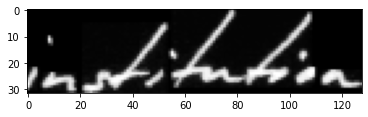



original_text =   .
predicted text = .

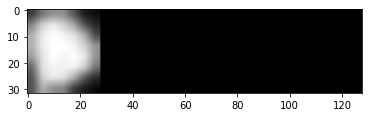



original_text =   Though
predicted text = Thongr-

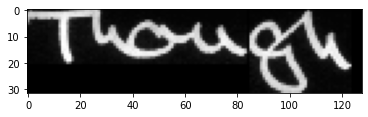



original_text =   they
predicted text = they

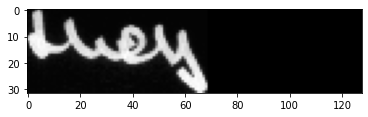



original_text =   may
predicted text = may

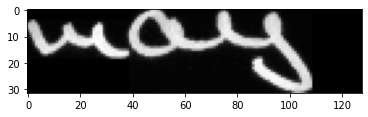



original_text =   gather
predicted text = ges-

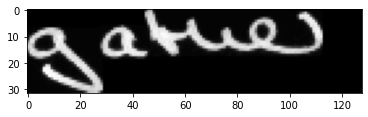



original_text =   some
predicted text = somey

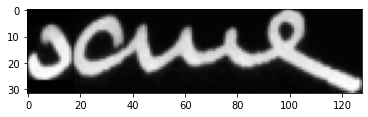



original_text =   support
predicted text = suport-

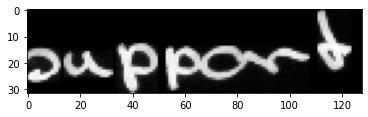



original_text =   ,
predicted text = ,

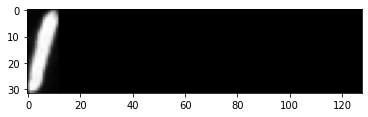



original_text =   a
predicted text = a-

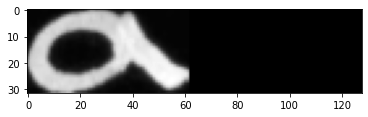



original_text =   large
predicted text = laarge-

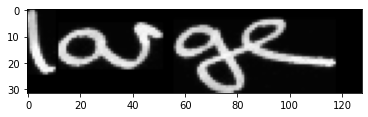



original_text =   majority
predicted text = majority

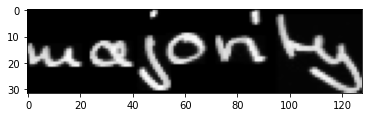



original_text =   of
predicted text = ofy

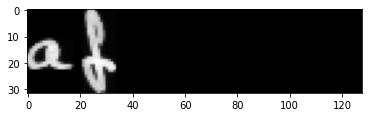



original_text =   Labour
predicted text = Laabousr-

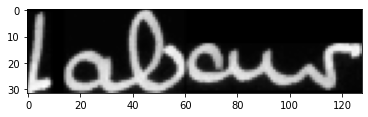



original_text =   MPs
predicted text = NPPs.

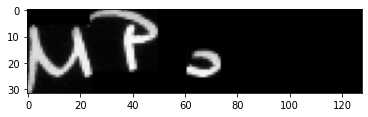



original_text =   are
predicted text = are-

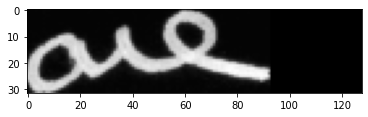



original_text =   to
predicted text = o-

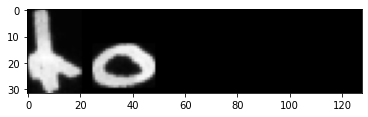



original_text =   turn
predicted text = turay

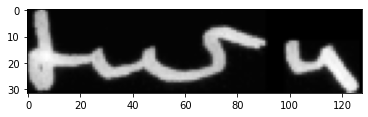



original_text =   down
predicted text = downy

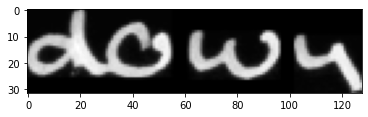



original_text =   the
predicted text = he-

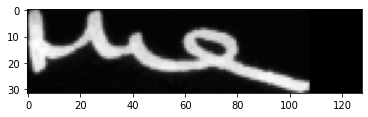



original_text =   Foot-
predicted text = Foots-

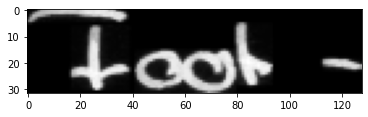



original_text =   be
predicted text = bbe-

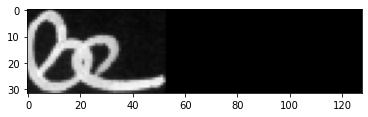



original_text =   that
predicted text = that-

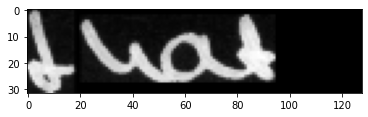



original_text =   as
predicted text = aas-

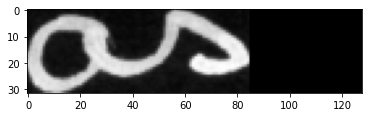



original_text =   Labour
predicted text = Labous-

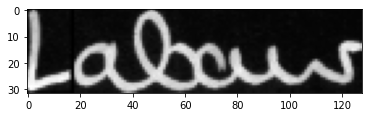



original_text =   MPs
predicted text = MPsy

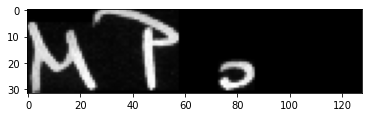



original_text =   opposed
predicted text = oppoeed

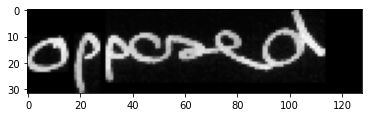



original_text =   the
predicted text = the-

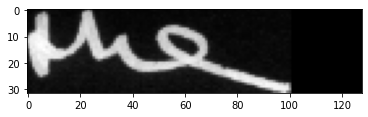



original_text =   Bill
predicted text = Billy

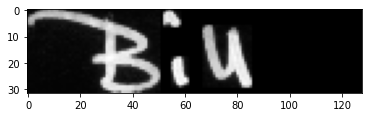



original_text =   which
predicted text = whithy

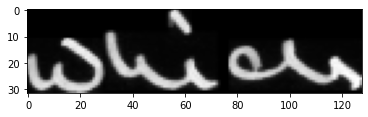

In [30]:
act_model = Model(input_layer, output_layer)
# load the saved best model weights
act_model.load_weights(filepath)
# predict outputs on validation images
prediction = act_model.predict(train_images[140:170])
 
# use CTC decoder
decoded = tf_keras_backend.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = tf_keras_backend.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[140+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[140+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [23]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

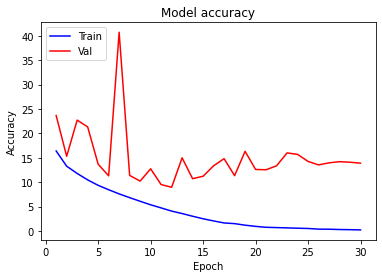

In [25]:
plotgraph(epochs, loss, val_loss)

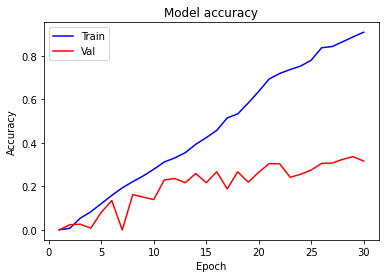

In [26]:
plotgraph(epochs, acc, val_acc)